In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
# Load data
df_umkm = pd.read_csv('/content/dataset_scaled.csv')

In [5]:
# Create new features
df_umkm['workforce_total'] = df_umkm['tenaga_kerja_perempuan'] + df_umkm['tenaga_kerja_laki_laki']

def categorize_profit(profit_value):
    thresholds = {'low': -0.5, 'medium': 0.5}
    if profit_value < thresholds['low']:
        return 'low'
    elif profit_value < thresholds['medium']:
        return 'medium'
    return 'high'

df_umkm['profit_category'] = df_umkm['laba'].apply(categorize_profit)
profit_encoder = LabelEncoder()
df_umkm['profit_category_encoded'] = profit_encoder.fit_transform(df_umkm['profit_category'])

In [6]:
# Select model features
model_features = [
    'workforce_total', 'aset', 'omset', 'kapasitas_produksi',
    'status_legalitas_Terdaftar', 'tahun_berdiri', 'biaya_karyawan',
    'jumlah_pelanggan'
] + [col for col in df_umkm.columns if col.startswith('marketplace_')]

X_features = df_umkm[model_features]
y_target = df_umkm['profit_category_encoded']

In [7]:
# Split dataset
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)


In [8]:
# Train LightGBM model
classifier = LGBMClassifier(random_state=42)
classifier.fit(X_train_set, y_train_set)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 8
[LightGBM] [Info] Start training from score -1.049740
[LightGBM] [Info] Start training from score -1.044424
[LightGBM] [Info] Start training from score -1.210404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(random_state=42)

## Evaluation

In [9]:
# Evaluate model performance
y_predicted = classifier.predict(X_test_set)
print("Model Evaluation Results:")
print(classification_report(y_test_set, y_predicted, target_names=profit_encoder.classes_))

Model Evaluation Results:
              precision    recall  f1-score   support

        high       1.00      0.99      1.00       610
         low       1.00      0.99      0.99       614
      medium       0.98      0.99      0.98       519

    accuracy                           0.99      1743
   macro avg       0.99      0.99      0.99      1743
weighted avg       0.99      0.99      0.99      1743



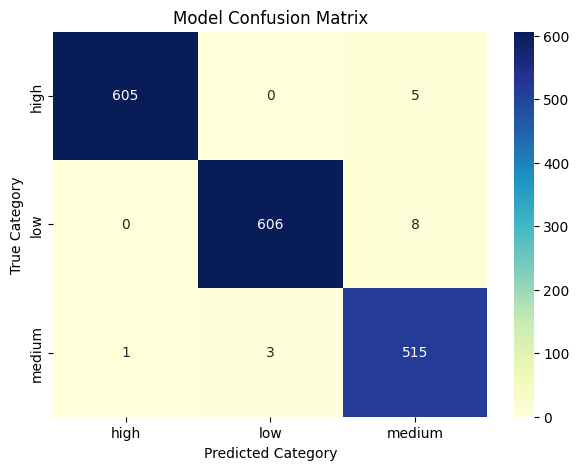

In [10]:
# Confusion matrix visualization
cm_data = confusion_matrix(y_test_set, y_predicted)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_data, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=profit_encoder.classes_, yticklabels=profit_encoder.classes_)
plt.title('Model Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.show()

## Bussiness Insight

In [14]:
# Generate complex business recommendations
def rekomendasi_kompleks(row):
    kategori = profit_encoder.inverse_transform([row['profit_category_encoded']])[0]
    legalitas = row['status_legalitas_Terdaftar']
    tenaga_kerja = row['workforce_total']
    omset = row['omset']
    aset = row['aset']
    tahun_berdiri = row['tahun_berdiri']
    jumlah_pelanggan = row['jumlah_pelanggan']

    if kategori == 'low':
        if legalitas == 0 and tenaga_kerja < 5:
            return "Lakukan legalisasi usaha, ikuti pelatihan manajemen keuangan, dan rekrut tenaga kerja tambahan."
        elif legalitas == 1 and omset < df_umkm['omset'].quantile(0.25):
            return "Tingkatkan strategi pemasaran digital dan optimasi biaya operasional."
        elif aset < df_umkm['aset'].quantile(0.3):
            return "Cari pendanaan mikro untuk peningkatan aset dan pelatihan efisiensi produksi."
        return "Fokus pada penghematan biaya dan diversifikasi produk untuk meningkatkan pendapatan."

    elif kategori == 'medium':
        if tenaga_kerja > 15 and omset > df_umkm['omset'].quantile(0.5):
            return "Akses pinjaman mikro untuk ekspansi produksi dan tingkatkan kehadiran di marketplace."
        elif tahun_berdiri < 3:
            return "Perkuat branding dan jaringan pelanggan melalui promosi dan kemitraan lokal."
        elif jumlah_pelanggan < df_umkm['jumlah_pelanggan'].quantile(0.4):
            return "Tingkatkan pelayanan pelanggan dan eksplorasi saluran penjualan baru."
        return "Lakukan evaluasi rutin dan pelatihan karyawan untuk meningkatkan produktivitas."

    elif kategori == 'high':
        if legalitas == 1 and aset > df_umkm['aset'].quantile(0.7):
            return "Manfaatkan status legal untuk kemitraan strategis dan ekspansi pasar internasional."
        elif tenaga_kerja > 20:
            return "Investasi pada teknologi otomasi dan perluasan kapasitas produksi."
        elif jumlah_pelanggan > df_umkm['jumlah_pelanggan'].quantile(0.6):
            return "Kembangkan program loyalitas pelanggan dan diversifikasi portofolio produk."
        return "Eksplorasi peluang investasi dan kembangkan strategi ekspansi jangka panjang."

    return "Lakukan monitoring berkala untuk menjaga stabilitas usaha."

df_umkm['rekomendasi'] = df_umkm.apply(rekomendasi_kompleks, axis=1)

print("\n Rekomendasi Kompleks untuk UMKM (Sampel):")
display(df_umkm[['nama_usaha', 'profit_category', 'rekomendasi']].head(10))


 Rekomendasi Kompleks untuk UMKM (Sampel):


,nama_usaha,profit_category,rekomendasi
0,UD. Alif Pamungkas,low,"Lakukan legalisasi usaha, ikuti pelatihan mana..."
1,UD. Zidanar Panji,high,Manfaatkan status legal untuk kemitraan strate...
2,UD. Winda Jayengprana,medium,Perkuat branding dan jaringan pelanggan melalu...
3,UD. Damaris Satria,low,"Lakukan legalisasi usaha, ikuti pelatihan mana..."
4,UD. Qasya Wiratama,low,"Lakukan legalisasi usaha, ikuti pelatihan mana..."
5,UD. Grego Wiraatmaja Nara,low,"Lakukan legalisasi usaha, ikuti pelatihan mana..."
6,UD. Mika Bagaskara,low,Tingkatkan strategi pemasaran digital dan opti...
7,UD. Yora Selaras,low,"Lakukan legalisasi usaha, ikuti pelatihan mana..."
8,UD. Wenny Langit,high,Eksplorasi peluang investasi dan kembangkan st...
9,UD. Fani Wijaya,high,Kembangkan program loyalitas pelanggan dan div...


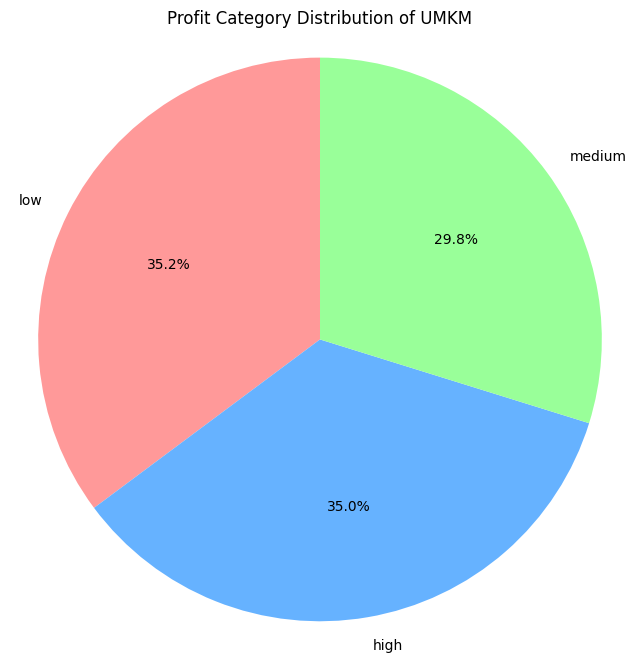

In [12]:
# Visualization: Pie chart for profit category distribution
plt.figure(figsize=(8, 8))
profit_counts = df_umkm['profit_category'].value_counts()
plt.pie(profit_counts, labels=profit_counts.index, autopct='%1.1f%%',
        colors=['#FF9999', '#66B2FF', '#99FF99'], startangle=90)
plt.title('Profit Category Distribution of UMKM')
plt.axis('equal')
plt.show()

<ipython-input-13-4abcca65ca95>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=model_features, x=feature_weights, palette='coolwarm')


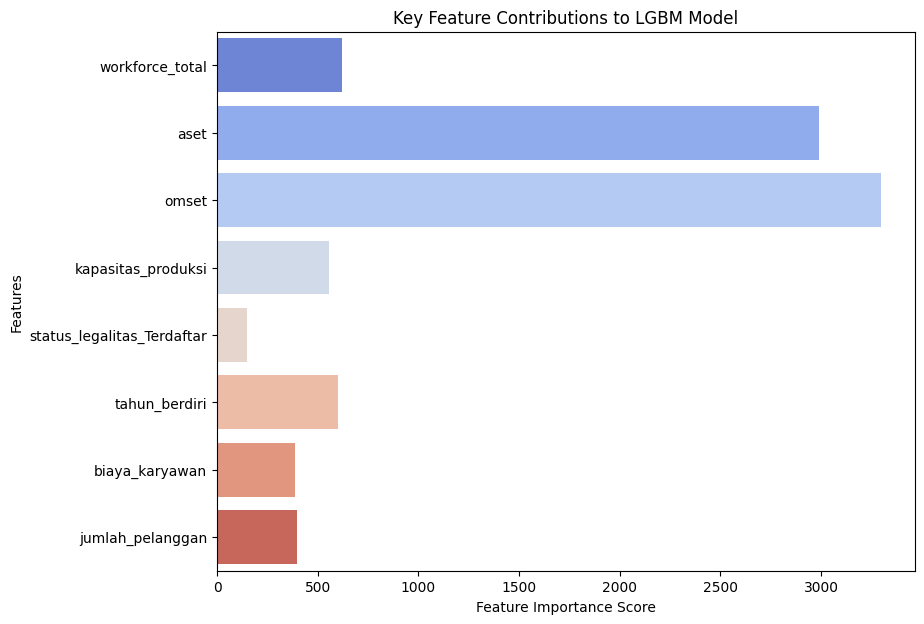

In [13]:
# Visualization: Feature importance with horizontal bar plot
feature_weights = classifier.feature_importances_
plt.figure(figsize=(9, 7))
sns.barplot(y=model_features, x=feature_weights, palette='coolwarm')
plt.title('Key Feature Contributions to LGBM Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()